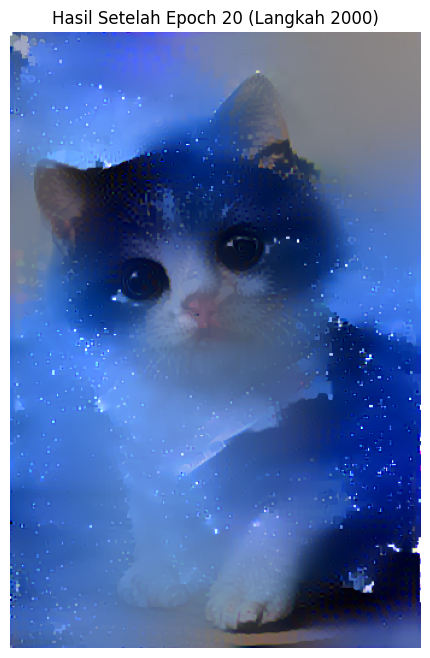

Total waktu pemrosesan: 145.05 detik


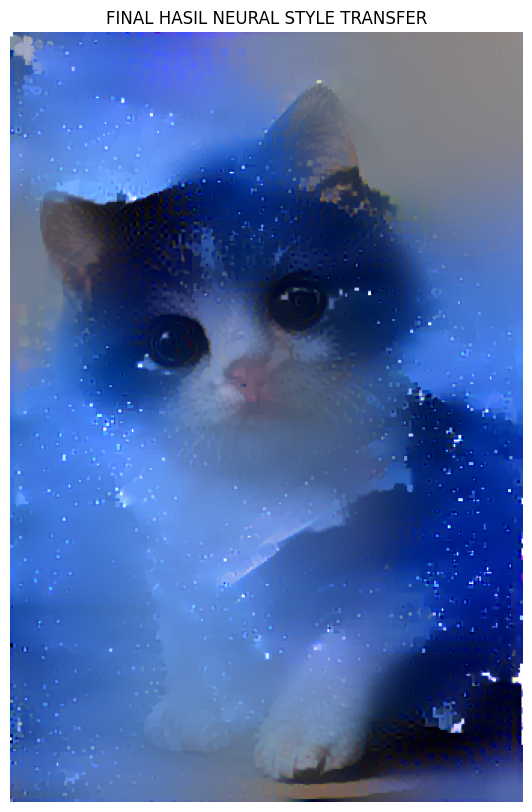

Gambar hasil disimpan sebagai 'hasil_style_transfer_halus.png' di Colab Anda.


In [2]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import time
import os

# Pastikan TensorFlow menggunakan GPU jika tersedia
print("TensorFlow Version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("GPU tersedia dan akan digunakan.")
else:
    print("Tidak ada GPU yang terdeteksi, menggunakan CPU.")

# --- 1. Pengaturan Gambar dan Hyperparameters ---

# Path Gambar Gaya (Style Image) - File 1.jpg yang diunggah
style_image_path = '/content/1.jpg'
# Path Gambar Konten (Content Image) - File 3.jpg yang diunggah
content_image_path = '/content/3.jpg'

# Hyperparameters untuk kontrol LOSS (Telah Ditingkatkan)
STYLE_WEIGHT = 1e-1    # Gaya Kuat (Ditingkatkan dari 1e-2)
CONTENT_WEIGHT = 1e4   # Konten Dominan
TV_WEIGHT = 1e3        # BARU: Menambahkan Total Variation Loss untuk menghaluskan gambar (Bisa disesuaikan, 1e3 adalah nilai awal yang baik)

# Hyperparameters untuk kontrol iterasi
EPOCHS = 20
STEPS_PER_EPOCH = 100
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH


# --- 2. Fungsi Loading dan Utilitas Gambar ---

def load_img(path_or_url):
    """Memuat dan memproses gambar dari path lokal atau URL."""
    max_dim = 512
    image_path = path_or_url

    # Menangani URL
    if path_or_url.startswith('http://') or path_or_url.startswith('https://'):
        print(f"Mengunduh gambar dari URL: {path_or_url[:50]}...")
        try:
            image_path = tf.keras.utils.get_file(os.path.basename(path_or_url).split('?')[0], origin=path_or_url)
        except Exception as e:
            print(f"Gagal mengunduh URL. Error: {e}")
            return None

    try:
        # Membaca file gambar
        img = tf.io.read_file(image_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
    except tf.errors.NotFoundError:
        print(f"ERROR: File tidak ditemukan di {image_path}. Pastikan file sudah diunggah dan path benar.")
        return None
    except Exception as e:
        print(f"ERROR saat memproses gambar di {image_path}. Error: {e}")
        return None

    # Mengubah ukuran gambar
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    """Menampilkan gambar."""
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

# --- Memuat Gambar ---
content_image = load_img(content_image_path)
style_image = load_img(style_image_path)

if content_image is None or style_image is None:
    print("Proses dihentikan karena gagal memuat gambar.")
    exit()

# Tampilkan Gambar Sumber
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
imshow(content_image, f'Content Image ({content_image_path.split("/")[-1]})')

plt.subplot(1, 2, 2)
imshow(style_image, f'Style Image ({style_image_path.split("/")[-1]})')
plt.show()

# --- 3. Model VGG19 dan Feature Extraction ---

# Definisikan layer yang akan digunakan
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """Membuat model Keras yang mengembalikan output dari `layer_names` dari VGG19."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    """Menghitung Gram Matrix untuk representasi gaya."""
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

class StyleContentModel(tf.keras.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_features = [gram_matrix(style_output)
                          for style_output in style_outputs]

        content_features = [content_output for content_output in content_outputs]

        return {'content': content_features,
                'style': style_features}

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

# --- 4. Fungsi Loss dan Optimasi (Diperbarui dengan TV Loss) ---

optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def clip_0_1(image):
    """Mengklip nilai piksel gambar agar tetap dalam rentang [0, 1]."""
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

@tf.function()
def train_step(image):
    """Melakukan satu langkah optimasi (gradien descent)."""
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        # 1. Style Loss
        style_loss = tf.add_n([tf.reduce_mean((style_output - style_target)**2)
                               for style_output, style_target in zip(style_outputs, style_targets)])
        style_loss *= STYLE_WEIGHT / num_style_layers

        # 2. Content Loss
        content_loss = tf.add_n([tf.reduce_mean((content_output - content_target)**2)
                                 for content_output, content_target in zip(content_outputs, content_targets)])
        content_loss *= CONTENT_WEIGHT / num_content_layers

        # 3. Total Variation Loss (TV Loss) BARU
        # Ini menghitung perbedaan antara piksel yang berdekatan untuk menghukum perubahan piksel yang terlalu tajam/noise.
        tv_loss = tf.image.total_variation(image)
        tv_loss *= TV_WEIGHT

        total_loss = style_loss + content_loss + tv_loss

    grad = tape.gradient(total_loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

# --- 5. Proses Iterasi dan Visualisasi Hasil ---

start = time.time()

print(f"Memulai style transfer untuk total {TOTAL_STEPS} langkah...")

step = 0
for n in range(EPOCHS):
    for m in range(STEPS_PER_EPOCH):
        step += 1
        train_step(image)
        if step % 50 == 0:
            print(f"Langkah {step}/{TOTAL_STEPS} | Epoch {n+1}/{EPOCHS}")

    display.clear_output(wait=True)
    plt.figure(figsize=(8, 8))
    imshow(image.read_value(), title=f"Hasil Setelah Epoch {n+1} (Langkah {step})")
    plt.show()

end = time.time()
print(f"Total waktu pemrosesan: {end - start:.2f} detik")

# Final Result
plt.figure(figsize=(10, 10))
imshow(image.read_value(), 'FINAL HASIL NEURAL STYLE TRANSFER')
plt.show()

# Simpan hasil gambar
final_image = PIL.Image.fromarray(np.uint8(image.read_value()[0]*255))
output_filename = "hasil_style_transfer_halus.png"
final_image.save(output_filename)
print(f"Gambar hasil disimpan sebagai '{output_filename}' di Colab Anda.")